In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the dataset
file_path = 'index_rev.csv'  # Update the path if necessary
df = pd.read_csv(file_path)
df.head()


,Unnamed: 0,neighbourhood,lacking_canopy_z,pop_density_z,total_pop_z,homeowners_core_z,total_core_z,tennants_core_z,owners_30pct_z,total_30pct_z,...,unsuitable_housing_z_VI,lico_aftertax_z_VI,lim_aftertax_z_VI,renters_z_VI,visible_minority_z_VI,unemployed_z_VI,temperature_z_VI,canopy_target_z_VI,unweighted_score,weighted_score
0,0,ABBOTTSFIELD,0.717509,1.001598,-0.688575,1.072485,1.487266,1.405917,0.212180,0.604482,...,6,6,6,4,4,3,5,4,158,NaN
1,1,ALBANY,1.383038,-0.869779,-0.731552,-0.115825,-0.777320,-0.875576,0.898069,0.289850,...,3,4,3,4,4,3,3,5,112,NaN
2,2,ALBERTA AVENUE,-1.545291,0.924028,1.093012,1.459977,1.243387,0.997047,0.261172,0.875065,...,4,4,4,4,4,5,3,2,137,NaN
3,3,ALDERGROVE,-0.081127,0.381038,0.676918,0.581661,0.546592,0.457339,-0.490040,0.308728,...,5,3,3,3,4,4,4,3,124,NaN
4,4,ALLARD,1.516144,1.593878,1.917387,-0.451652,-0.352275,-0.270449,0.702101,0.566726,...,4,3,3,3,5,3,4,5,119,NaN


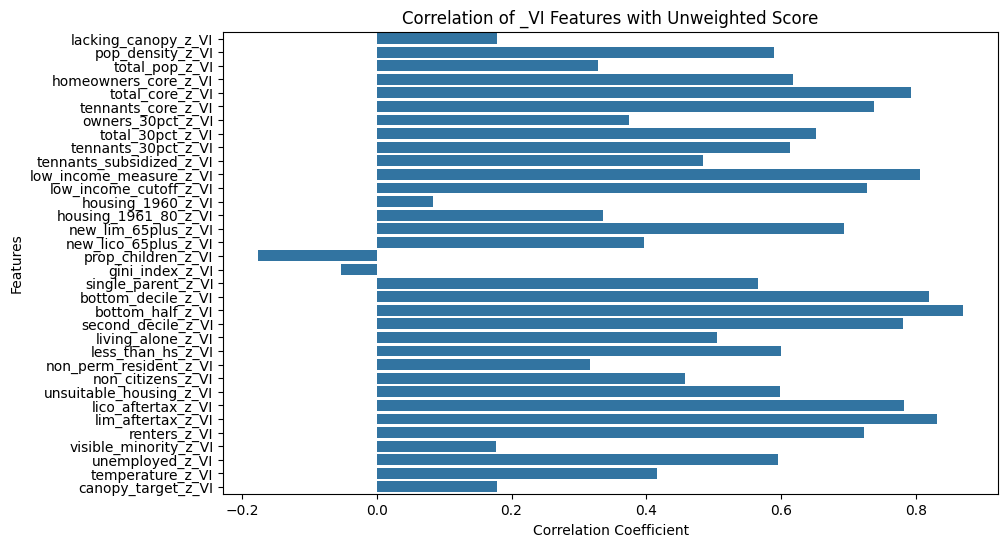

In [2]:
# Selecting only the columns ending with '_VI' and the 'unweighted_score'
vi_columns = [col for col in df.columns if col.endswith('_VI')]
vi_data = df[vi_columns + ['unweighted_score']]

# Calculating the correlation matrix
correlation_matrix = vi_data.corr()

# Isolating the correlation of features with 'unweighted_score'
correlation_with_unweighted_score = correlation_matrix['unweighted_score'].drop('unweighted_score')

# Visualizing the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_unweighted_score.values, y=correlation_with_unweighted_score.index)
plt.title('Correlation of _VI Features with Unweighted Score')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


In [3]:
# Data Cleaning and Preprocessing

# Dropping the 'Unnamed: 0' column as it seems to be an index column
df_cleaned = df.drop(columns=['Unnamed: 0'])

# Checking for missing values
missing_values = df_cleaned.isnull().sum()

# Checking for duplicate rows
duplicate_rows = df_cleaned.duplicated().sum()

# Summary of missing values and duplicates
missing_values_summary = missing_values[missing_values > 0]
duplicate_rows_summary = {'Duplicate Rows': duplicate_rows}

missing_values_summary, duplicate_rows_summary


(housing_1960_z            1
 housing_1961_80_z         1
 prop_children_z           1
 single_parent_z           1
 bottom_decile_z           1
 bottom_half_z             1
 second_decile_z           1
 living_alone_z            1
 less_than_hs_z            1
 non_perm_resident_z       1
 non_citizens_z            1
 unsuitable_housing_z      1
 renters_z                 1
 visible_minority_z        1
 unemployed_z              1
 temperature_z             7
 weighted_score          274
 dtype: int64,
 {'Duplicate Rows': 0})

In [4]:
# Excluding 'weighted_score' from the analysis
columns_with_missing = missing_values_summary.index.tolist()
columns_with_missing.remove('weighted_score')

# Detailed analysis of columns with missing values
missing_data_analysis = {}
for column in columns_with_missing:
    column_data = df_cleaned[column]
    missing_data_analysis[column] = {
        'Data Type': column_data.dtype,
        'Number of Missing Values': missing_values[column],
        'Percent Missing': (missing_values[column] / len(df_cleaned)) * 100,
        'Mean Value': column_data.mean(),
        'Median Value': column_data.median(),
        'Mode Value': column_data.mode()[0]
    }

missing_data_analysis_df = pd.DataFrame.from_dict(missing_data_analysis, orient='index')
missing_data_analysis_df


,Data Type,Number of Missing Values,Percent Missing,Mean Value,Median Value,Mode Value
housing_1960_z,float64,1,0.364964,2.478832e-03,-0.558647,-0.676721
housing_1961_80_z,float64,1,0.364964,3.969334e-03,-0.176275,-1.083628
prop_children_z,float64,1,0.364964,-4.316379e-03,0.228578,0.446864
single_parent_z,float64,1,0.364964,2.374388e-03,-0.128068,-0.671798
bottom_decile_z,float64,1,0.364964,5.871764e-03,-0.180502,-1.602992
bottom_half_z,float64,1,0.364964,8.625724e-03,0.000380,-2.932682
second_decile_z,float64,1,0.364964,6.691133e-03,-0.094925,-1.826679
living_alone_z,float64,1,0.364964,3.610225e-03,-0.259846,-0.592336
less_than_hs_z,float64,1,0.364964,-4.086768e-05,-0.090812,-2.313568
non_perm_resident_z,float64,1,0.364964,2.187821e-03,-0.222664,-0.597275


In [5]:
# Excluding 'weighted_score' from the analysis
columns_with_missing = missing_values_summary.index.tolist()
columns_with_missing.remove('weighted_score')

# Detailed analysis of columns with missing values
missing_data_analysis = {}
for column in columns_with_missing:
    column_data = df_cleaned[column]
    missing_data_analysis[column] = {
        'Data Type': column_data.dtype,
        'Number of Missing Values': missing_values[column],
        'Percent Missing': (missing_values[column] / len(df_cleaned)) * 100,
        'Mean Value': column_data.mean(),
        'Median Value': column_data.median(),
        'Mode Value': column_data.mode()[0]
    }

missing_data_analysis_df = pd.DataFrame.from_dict(missing_data_analysis, orient='index')
missing_data_analysis_df


,Data Type,Number of Missing Values,Percent Missing,Mean Value,Median Value,Mode Value
housing_1960_z,float64,1,0.364964,2.478832e-03,-0.558647,-0.676721
housing_1961_80_z,float64,1,0.364964,3.969334e-03,-0.176275,-1.083628
prop_children_z,float64,1,0.364964,-4.316379e-03,0.228578,0.446864
single_parent_z,float64,1,0.364964,2.374388e-03,-0.128068,-0.671798
bottom_decile_z,float64,1,0.364964,5.871764e-03,-0.180502,-1.602992
bottom_half_z,float64,1,0.364964,8.625724e-03,0.000380,-2.932682
second_decile_z,float64,1,0.364964,6.691133e-03,-0.094925,-1.826679
living_alone_z,float64,1,0.364964,3.610225e-03,-0.259846,-0.592336
less_than_hs_z,float64,1,0.364964,-4.086768e-05,-0.090812,-2.313568
non_perm_resident_z,float64,1,0.364964,2.187821e-03,-0.222664,-0.597275


In [6]:
# Performing imputation for the missing values
for column in columns_with_missing:
    # Deciding whether to use mean or median for imputation
    if abs(missing_data_analysis_df.loc[column, 'Mean Value'] - missing_data_analysis_df.loc[column, 'Median Value']) < 0.1:
        # Mean and median are close, so using mean for imputation
        impute_value = missing_data_analysis_df.loc[column, 'Mean Value']
    else:
        # Using mode for imputation when mean and median are not close
        impute_value = missing_data_analysis_df.loc[column, 'Mode Value']

    # Imputing missing values
    df_cleaned[column].fillna(impute_value, inplace=True)

# Rechecking for missing values to ensure imputation was successful
df_cleaned.isnull().sum().sum()


274

In [7]:
df_cleaned.isnull().sum().sum()

274

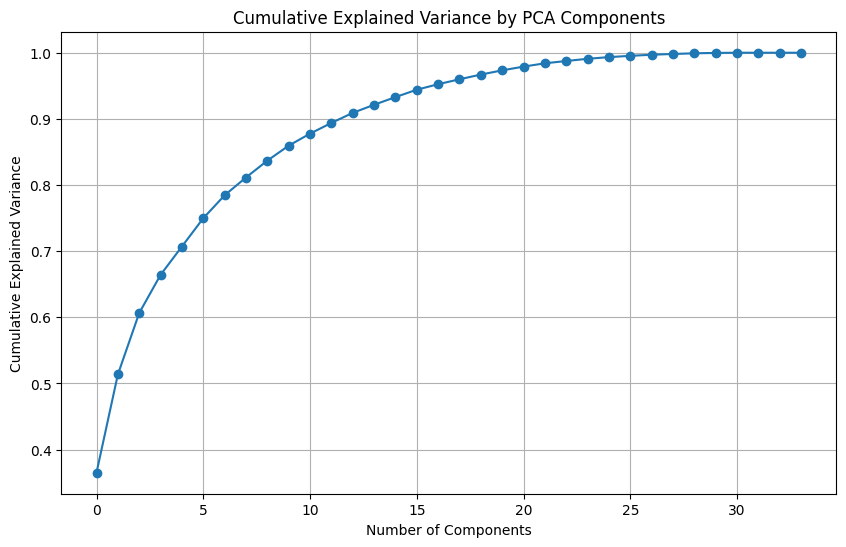

In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
# Check if the required modules are imported
try:
    import matplotlib.pyplot as plt
except ImportError as e:
    print(f"Error: {e}")
    print("Please make sure you have the required modules installed.")

# Check if the necessary variables are defined
try:
    if 'df_cleaned' not in locals():
        raise NameError("Variable 'df_cleaned' is not defined.")
except NameError as e:
    print(f"Error: {e}")
    print("Please make sure you have defined the necessary variables.")

# Selecting only the columns ending with '_z'
z_columns = [col for col in df_cleaned.columns if col.endswith('_z')]

# Check if any columns ending with '_z' are found
if not z_columns:
    print("Error: No columns ending with '_z' found in the dataframe.")
else:
    # Extract the subset of the dataframe with '_z' columns
    X_z = df_cleaned[z_columns]

    # Check if the subset dataframe is empty
    if X_z.empty:
        print("Error: Subset dataframe is empty.")
    else:
        try:
            # Performing PCA
            pca = PCA()
            pca.fit(X_z)

            # Getting the explained variance ratio for each principal component
            explained_variance_ratio = pca.explained_variance_ratio_

            # Check if explained variance ratio is empty
            if not explained_variance_ratio.any():
                print("Error: Explained variance ratio is empty.")
            else:
                # Plotting the cumulative explained variance
                cumulative_variance = np.cumsum(explained_variance_ratio)
                plt.figure(figsize=(10, 6))
                plt.plot(cumulative_variance, marker='o')
                plt.title('Cumulative Explained Variance by PCA Components')
                plt.xlabel('Number of Components')
                plt.ylabel('Cumulative Explained Variance')
                plt.grid(True)
                plt.show()
        except Exception as e:
            print(f"Error: {e}")
            print("An error occurred while performing PCA.")


In [18]:
pca_t = PCA(n_components=5, random_state=42)
pca_transformed = pca_t.fit_transform(X_z)


In [20]:
indicator_names = X_z.columns

# Get the loadings of each feature on each principal component
loadings = pca_t.components_

# Create a dictionary to store the indicators for each factor
factor_indicators = {}

# Iterate over each principal component
for i, component in enumerate(loadings):
    # Get the indices of the top features (indicators) for the current component
    top_feature_indices = np.argsort(np.abs(component))[::-1]
    
    # Get the top feature names (indicators) for the current component
    top_feature_names = indicator_names[top_feature_indices]
    
    # Store the top feature names (indicators) for the current component in the dictionary
    factor_indicators[f"Factor {i+1}"] = top_feature_names

# Print the indicators for each factor
for factor, indicators in factor_indicators.items():
    print(f"{factor}: {', '.join(indicators)}")


Factor 1: lim_aftertax_z, bottom_decile_z, low_income_measure_z, bottom_half_z, lico_aftertax_z, total_core_z, low_income_cutoff_z, second_decile_z, renters_z, tennants_core_z, new_lim_65plus_z, total_30pct_z, living_alone_z, tennants_30pct_z, homeowners_core_z, unemployed_z, less_than_hs_z, pop_density_z, single_parent_z, tennants_subsidized_z, unsuitable_housing_z, prop_children_z, housing_1961_80_z, temperature_z, new_lico_65plus_z, owners_30pct_z, non_citizens_z, housing_1960_z, non_perm_resident_z, total_pop_z, gini_index_z, lacking_canopy_z, canopy_target_z, visible_minority_z
Factor 2: lacking_canopy_z, canopy_target_z, visible_minority_z, prop_children_z, housing_1960_z, temperature_z, unsuitable_housing_z, non_citizens_z, gini_index_z, total_pop_z, living_alone_z, pop_density_z, owners_30pct_z, less_than_hs_z, single_parent_z, bottom_half_z, low_income_cutoff_z, renters_z, housing_1961_80_z, new_lim_65plus_z, total_30pct_z, lico_aftertax_z, bottom_decile_z, homeowners_core_z, 

In [21]:
import numpy as np

# Define the number of iterations
num_iterations = 5

# Initialize lists to store the results for each iteration
explained_variance_ratios = np.empty(num_iterations, dtype=object)
num_components = np.empty(num_iterations, dtype=int)

# Run multiple iterations of PCA
for i in range(num_iterations):
    # Vary the number of components in each iteration
    n_components = i + 1

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_z)

    # Store the results
    explained_variance_ratios[i] = pca.explained_variance_ratio_
    num_components[i] = n_components

    # Print the results for each iteration
    print(f"Iteration {i+1}:")
    print("Explained Variance Ratio:", explained_variance_ratios[i])
    print("Number of components:", num_components[i])
    print()

# Compare the results

# Find the index of the maximum explained variance ratio
max_variance_ratio_index = np.argmax([np.max(ratio) for ratio in explained_variance_ratios])
max_variance_ratio = explained_variance_ratios[max_variance_ratio_index]
max_components = num_components[max_variance_ratio_index]

# Print the best result
print("Best Result:")
print("Explained Variance Ratio:", max_variance_ratio)
print("Number of components:", max_components)


Iteration 1:
Explained Variance Ratio: [0.36504872]
Number of components: 1

Iteration 2:
Explained Variance Ratio: [0.36504872 0.14850618]
Number of components: 2

Iteration 3:
Explained Variance Ratio: [0.36504872 0.14850618 0.09287457]
Number of components: 3

Iteration 4:
Explained Variance Ratio: [0.36504872 0.14850618 0.09287457 0.05774192]
Number of components: 4

Iteration 5:
Explained Variance Ratio: [0.36504872 0.14850618 0.09287457 0.05774192 0.04281866]
Number of components: 5

Best Result:
Explained Variance Ratio: [0.36504872]
Number of components: 1


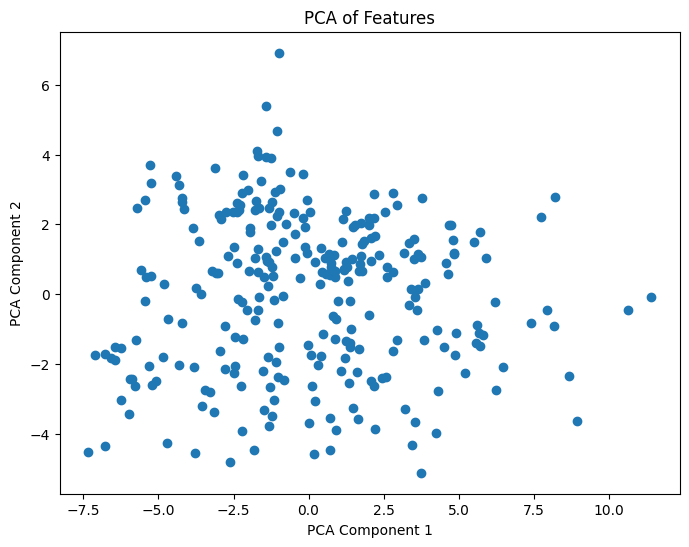

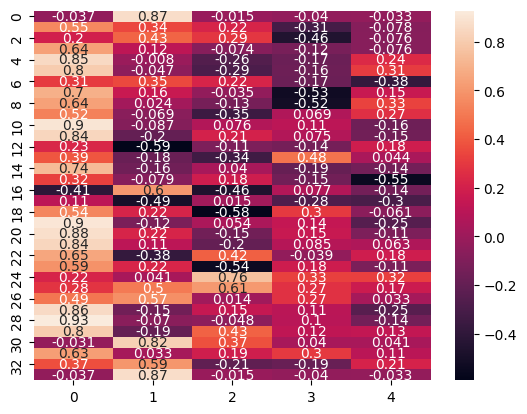

In [22]:

# Define X_pca before using it
X_pca = pca.transform(X_z)

# Scatter plot for first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Features')
plt.show()

# Correlation of original features with PCA components
correlation_matrix = np.corrcoef(X_z.T, X_pca.T)[:len(X_z.columns), len(X_z.columns):]
sns.heatmap(correlation_matrix, annot=True)
plt.show()


In [25]:
# Creating the Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
random_forest.fit(X_z, y)

# Extracting feature importances
feature_importances = pd.Series(random_forest.feature_importances_, index=X_z.columns)

# Visualizing the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importances from Random Forest Regression')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


NameError: name 'y' is not defined

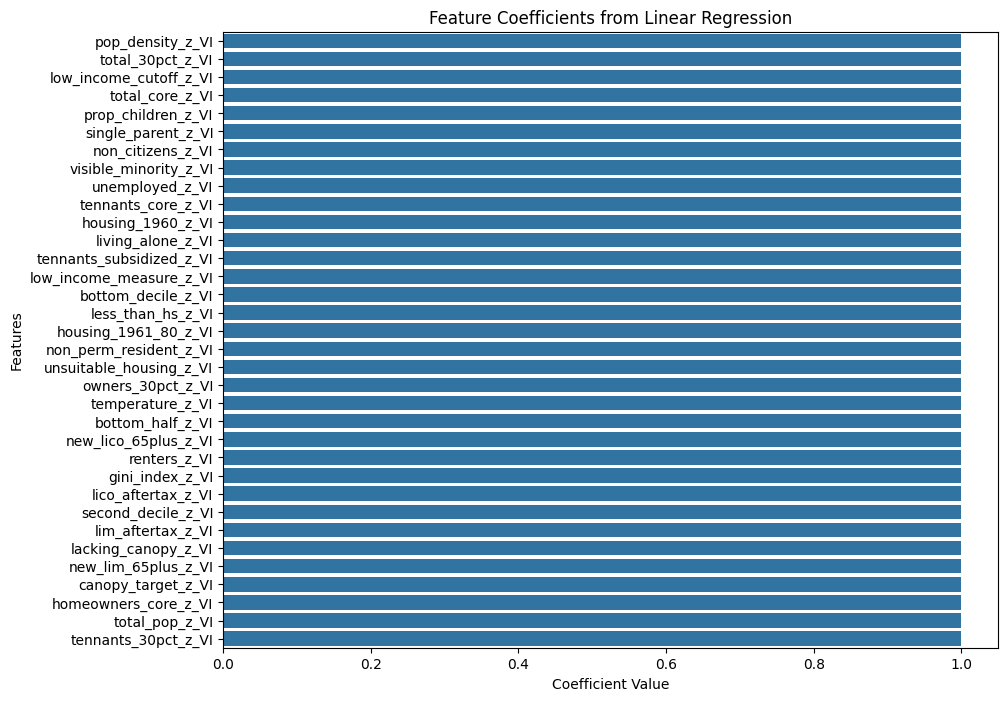

pop_density_z_VI            1.0
total_30pct_z_VI            1.0
low_income_cutoff_z_VI      1.0
total_core_z_VI             1.0
prop_children_z_VI          1.0
single_parent_z_VI          1.0
non_citizens_z_VI           1.0
visible_minority_z_VI       1.0
unemployed_z_VI             1.0
tennants_core_z_VI          1.0
housing_1960_z_VI           1.0
living_alone_z_VI           1.0
tennants_subsidized_z_VI    1.0
low_income_measure_z_VI     1.0
bottom_decile_z_VI          1.0
less_than_hs_z_VI           1.0
housing_1961_80_z_VI        1.0
non_perm_resident_z_VI      1.0
unsuitable_housing_z_VI     1.0
owners_30pct_z_VI           1.0
temperature_z_VI            1.0
bottom_half_z_VI            1.0
new_lico_65plus_z_VI        1.0
renters_z_VI                1.0
gini_index_z_VI             1.0
lico_aftertax_z_VI          1.0
second_decile_z_VI          1.0
lim_aftertax_z_VI           1.0
lacking_canopy_z_VI         1.0
new_lim_65plus_z_VI         1.0
canopy_target_z_VI          1.0
homeowne

In [23]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Preparing the data for regression analysis
X = df_cleaned[vi_columns]  # Independent variables
y = df_cleaned['unweighted_score']  # Dependent variable

# Performing the regression analysis
linear_reg = LinearRegression()
linear_reg.fit(X, y)

# Extracting the coefficients
feature_coefficients = pd.Series(linear_reg.coef_, index=X.columns)

# Sorting the coefficients for better visualization
sorted_feature_coefficients = feature_coefficients.sort_values(key=abs, ascending=False)

# Visualizing the coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_feature_coefficients.values, y=sorted_feature_coefficients.index)
plt.title('Feature Coefficients from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

sorted_feature_coefficients


Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


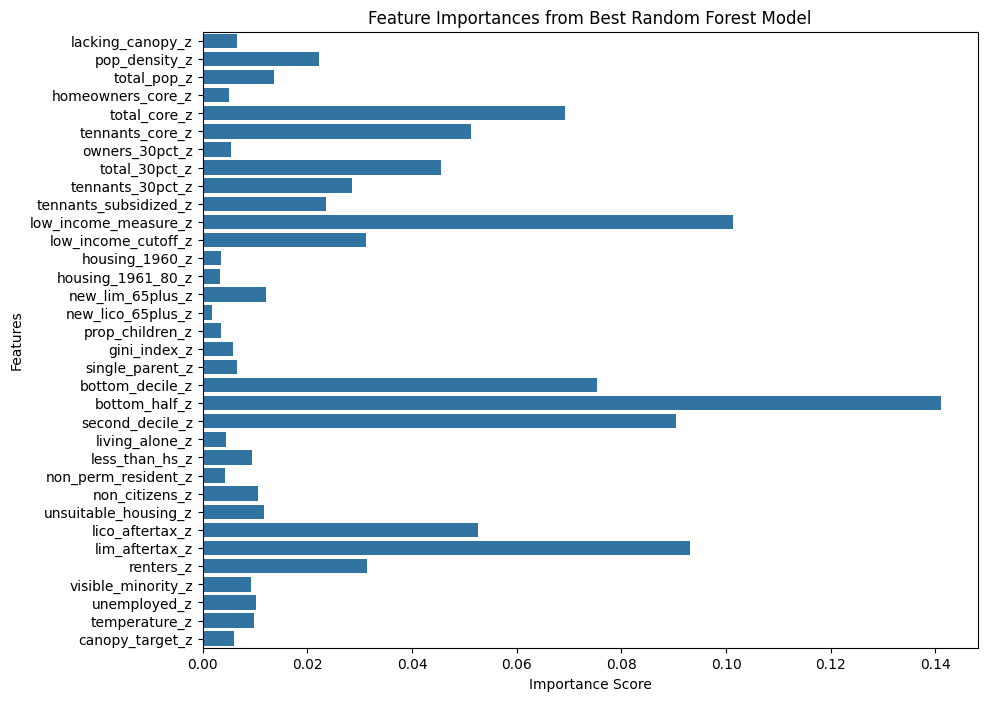

Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score for Random Forest: 0.8991196884058269


In [25]:
from sklearn.model_selection import GridSearchCV
# Robust Random Forest with GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_z, y)

best_rf_model = grid_search_rf.best_estimator_

# Feature importances from the best Random Forest model
rf_feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_z.columns)

# Visualizing feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=rf_feature_importances.values, y=rf_feature_importances.index)
plt.title('Feature Importances from Best Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Best parameters and score for Random Forest
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Score for Random Forest:", grid_search_rf.best_score_)


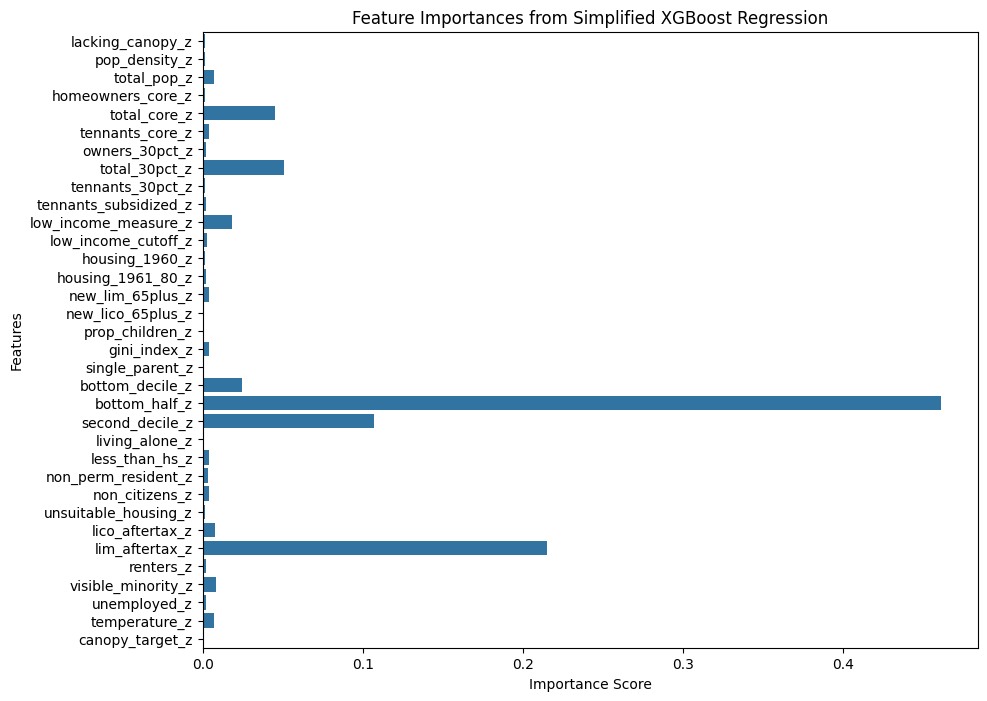

In [29]:
# Creating the XGBoost model with reduced complexity
xgb_model = xgb.XGBRegressor(n_estimators=50, random_state=42)

# Fitting the model to the '_z' features
xgb_model.fit(X_z, y)

# Extracting feature importances
xgb_feature_importances = pd.Series(xgb_model.feature_importances_, index=X_z.columns)

# Visualizing the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=xgb_feature_importances.values, y=xgb_feature_importances.index)
plt.title('Feature Importances from Simplified XGBoost Regression')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


Fitting 4 folds for each of 2400 candidates, totalling 9600 fits
Best neg_mean_squared_error: 0.4595092577580578
Best explained_variance: 0.47345295693139483
Best r2: 0.48545411277196887
Best neg_mean_squared_error: 0.4595092577580578
Best explained_variance: 0.47345295693139483
Best r2: 0.48545411277196887


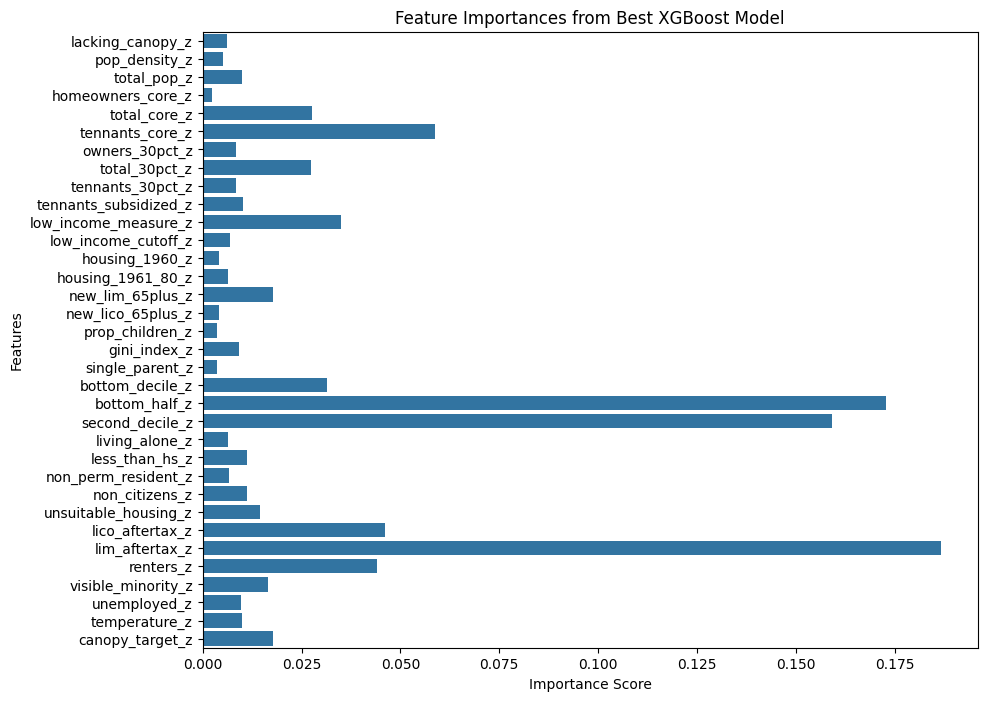

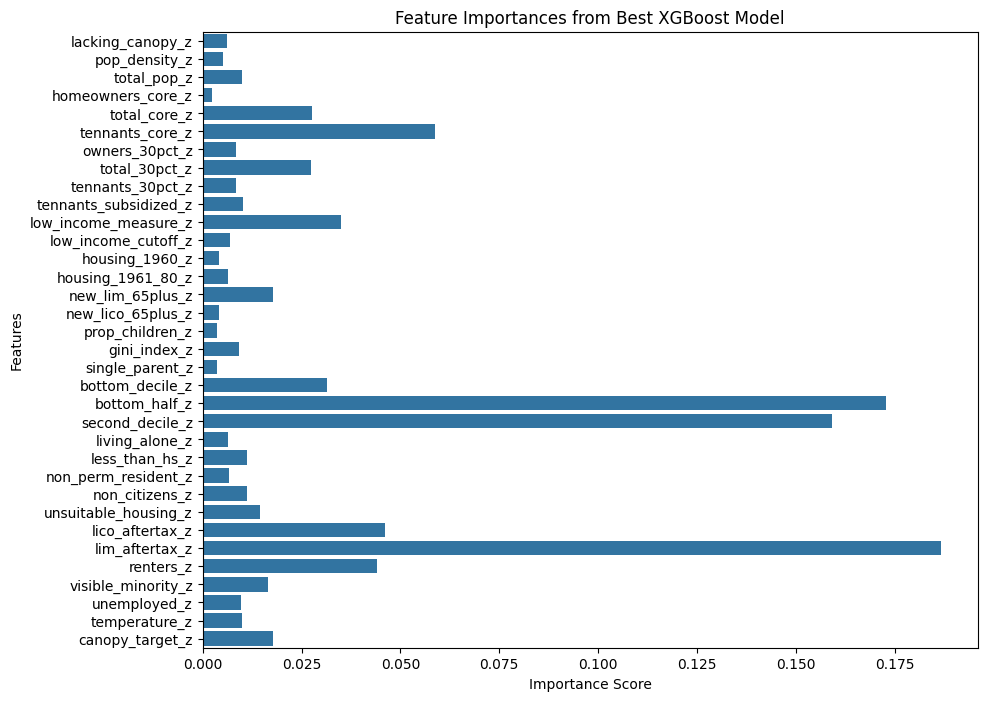

In [26]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


# Define the expanded parameter grid for XGBoost

param_grid = {
    "n_estimators": [50, 100, 200, 300, 400, 500],
    "max_depth": [3, 6, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.3, 0.5, 0.7, 1.0],
    "colsample_bytree": [0.3, 0.5, 0.7, 1.0]
}

# Define the scoring map with multiple metrics
scoring = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "explained_variance": "explained_variance",
    "r2": "r2",
}


# Create the XGBoost model

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)


# Set up GridSearchCV with parallelization
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scoring,
    cv=4,  # Increase number of cross-validation folds
    verbose=1,
    n_jobs=-1,
    refit="explained_variance",
)


# Fit the GridSearchCV

grid_search.fit(X_z, y)


# Best parameters and best scores for each metric

best_params = grid_search.best_params_

best_scores = grid_search.cv_results_["mean_test_explained_variance"]

# Convert best_scores to a dictionary
best_scores_dict = {
    metric: score for metric, score in zip(scoring.keys(), best_scores.tolist())
}

# Create an XGBoost model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
best_xgb_model.fit(X_z, y)

# Feature importances from the best model
best_xgb_feature_importances = pd.Series(
    best_xgb_model.feature_importances_, index=X_z.columns
)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=best_xgb_feature_importances.values, y=best_xgb_feature_importances.index)
plt.title("Feature Importances from Best XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
for metric, score in best_scores_dict.items():
    print(f"Best {metric}: {score}")

best_xgb_feature_importances = pd.Series(
    best_xgb_model.feature_importances_, index=X_z.columns
)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=best_xgb_feature_importances.values, y=best_xgb_feature_importances.index)
plt.title("Feature Importances from Best XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
for metric, score in best_scores_dict.items():
    print(f"Best {metric}: {score}")






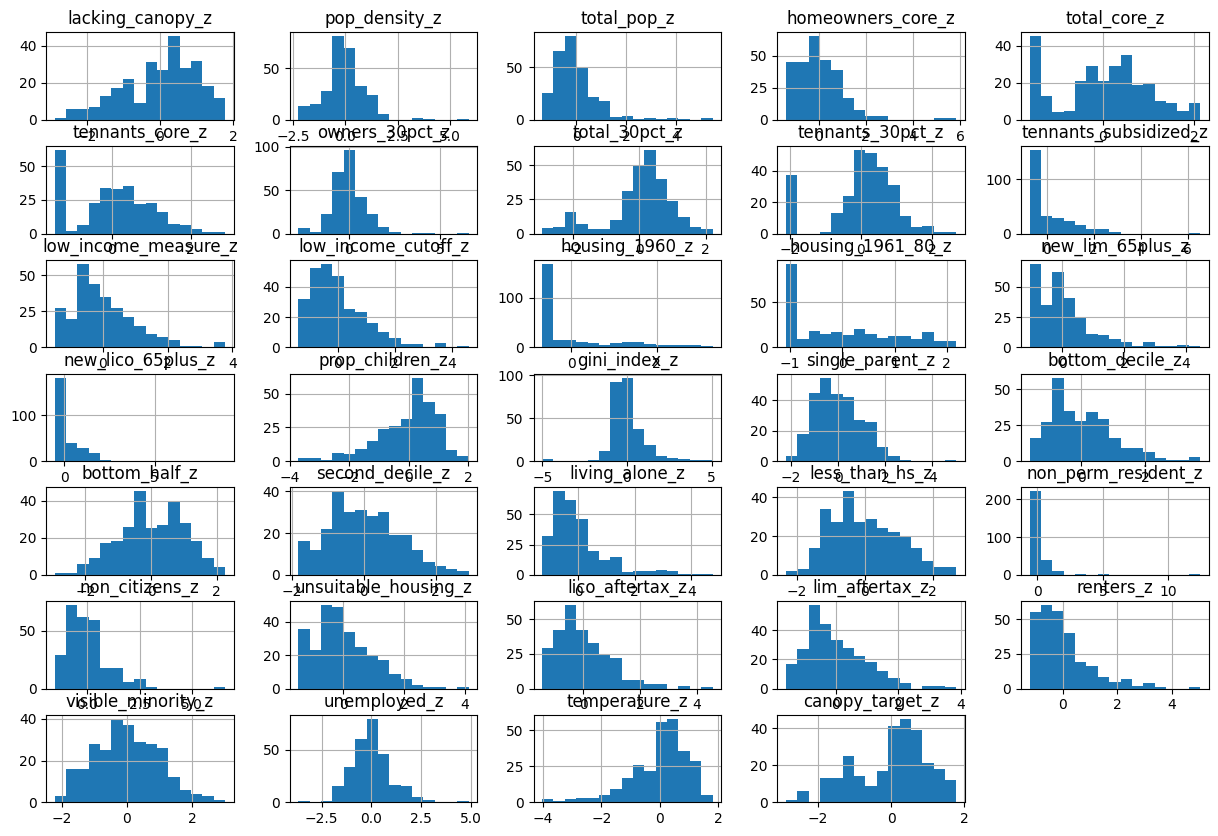

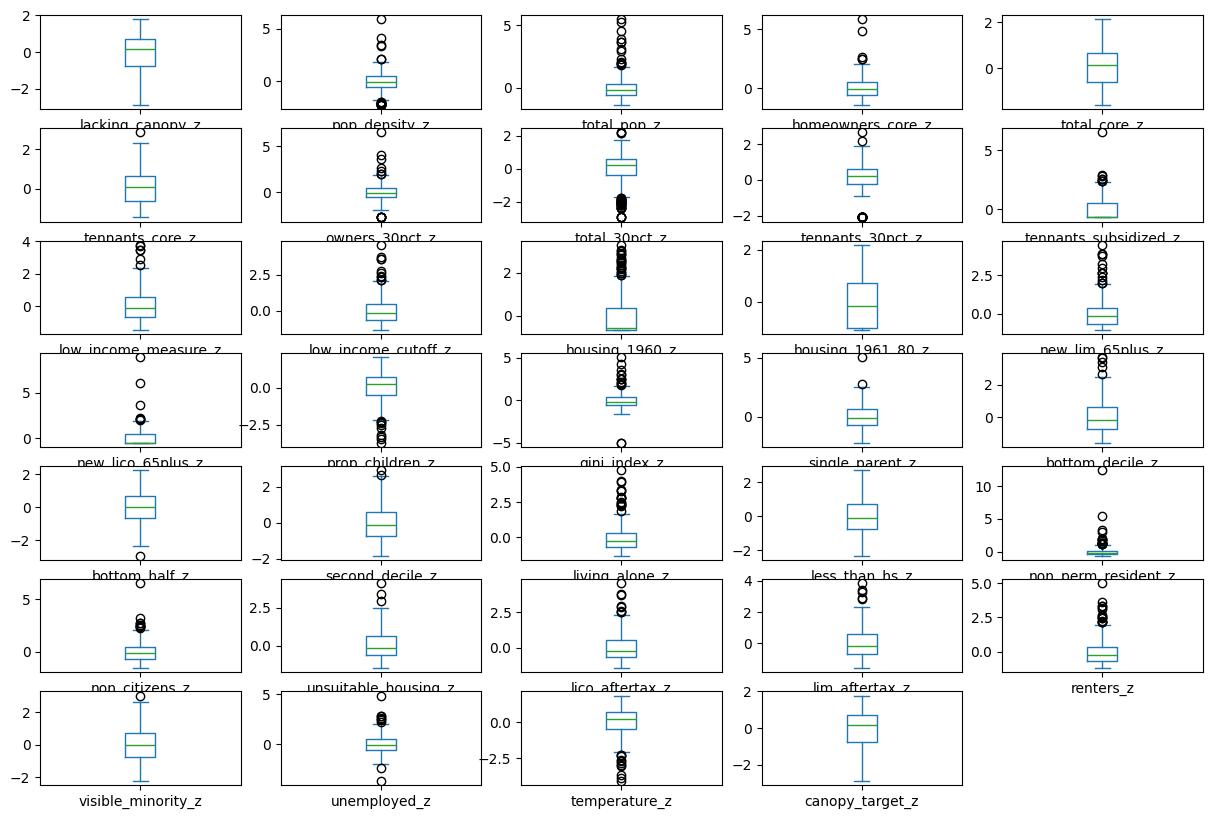

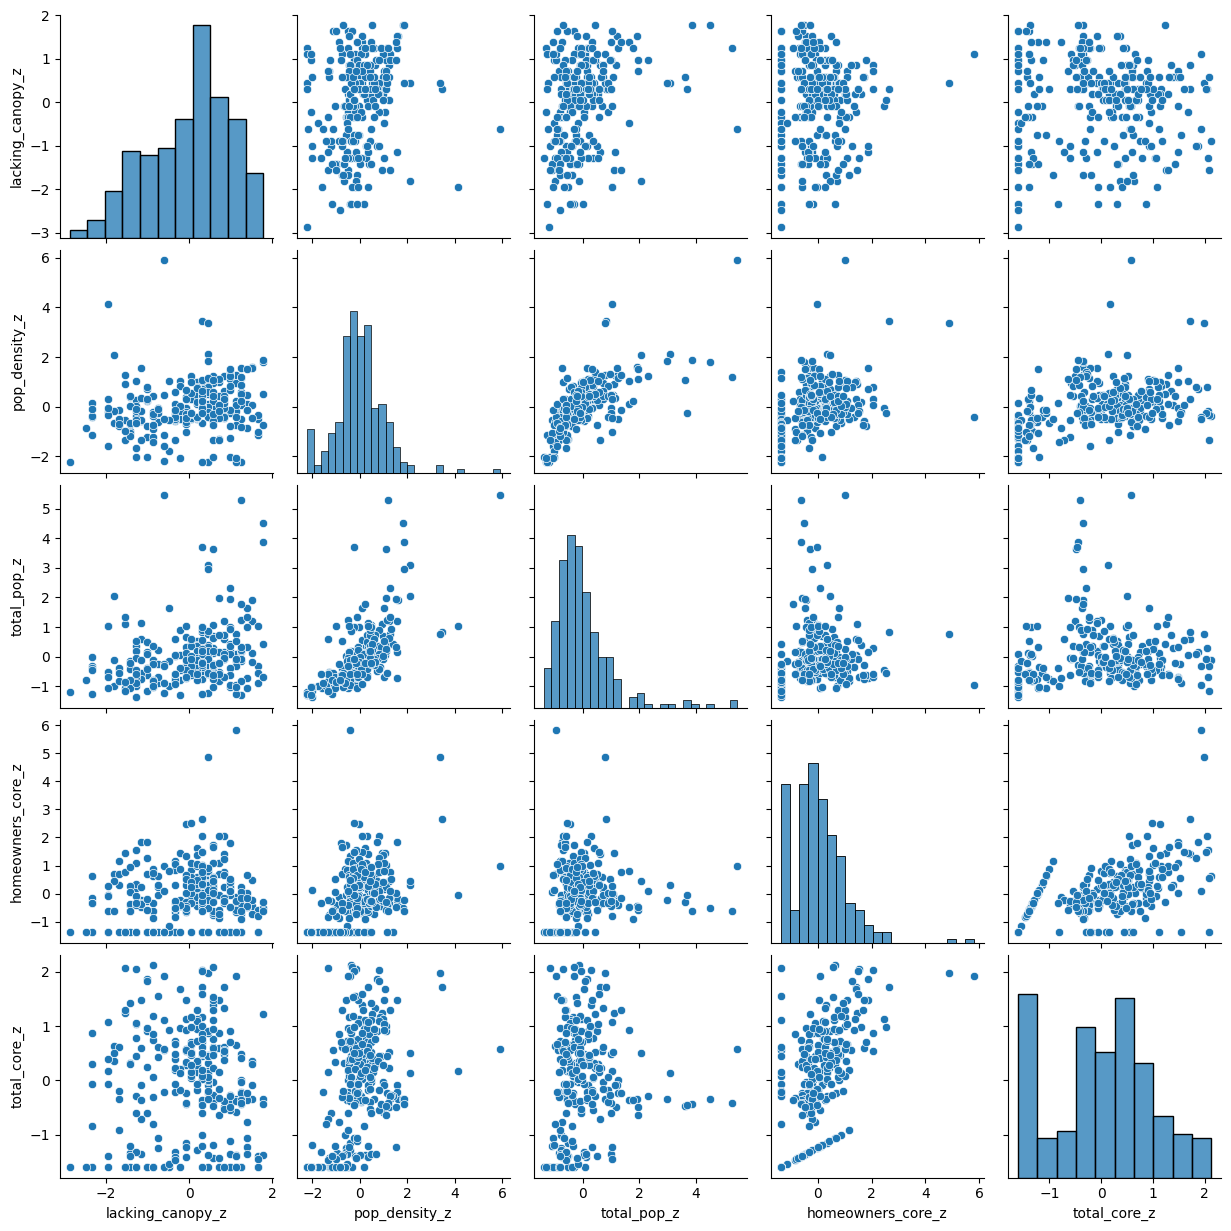

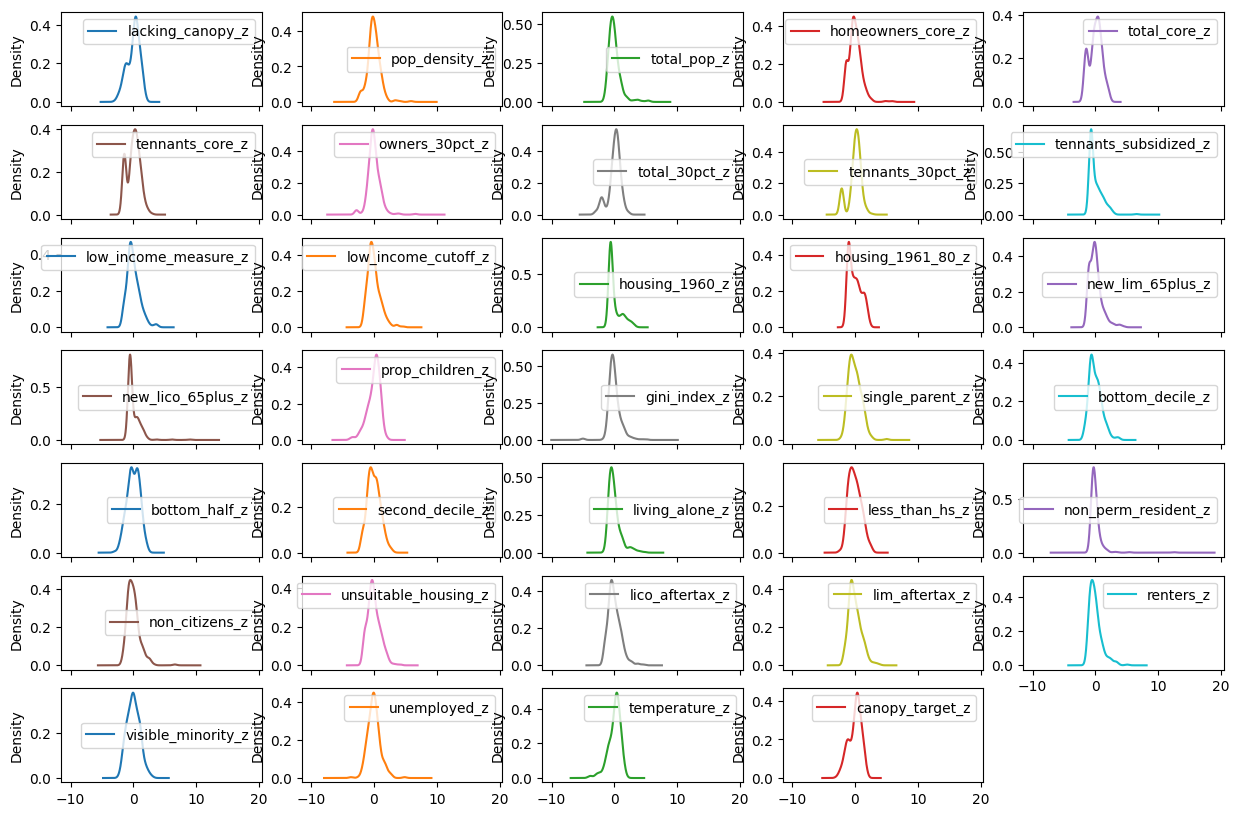

NameError: name 'random_forest' is not defined

In [27]:
# Histograms for each feature
X_z.hist(bins=15, figsize=(15, 10), layout=(7, 5))  # Adjust layout based on the number of features
plt.show()

# Box plots for each feature
X_z.plot(kind='box', subplots=True, layout=(7, 5), figsize=(15, 10))  # Adjust layout
plt.show()

# Pairwise relationships
sns.pairplot(X_z.iloc[:, :5])  # Adjust for selected features
plt.show()

# KDE plots for each feature
X_z.plot(kind='kde', subplots=True, layout=(7, 5), figsize=(15, 10))  # Adjust layout
plt.show()

# Fit the Random Forest model
random_forest.fit(X_z, y)

# Comparing feature importances from Random Forest
feature_importances_rf = pd.Series(random_forest.feature_importances_, index=X_z.columns)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances_rf.values, y=feature_importances_rf.index)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances_rf.values, y=feature_importances_rf.index)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


# Comparing feature importances from PCA
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


c:\Users\toast\Documents\GitHub\spatial_stats\spatial_stats_py\.venv\lib\site-packages\factor_analyzer\factor_analyzer.py:443: RuntimeWarning: invalid value encountered in log
  error = -(np.sum(np.log(values) - values) - n_factors + corr_mtx.shape[0])
c:\Users\toast\Documents\GitHub\spatial_stats\spatial_stats_py\.venv\lib\site-packages\factor_analyzer\factor_analyzer.py:574: UserWarning: Failed to converge: ABNORMAL_TERMINATION_IN_LNSRCH
  warnings.warn(f"Failed to converge: {res.message}")


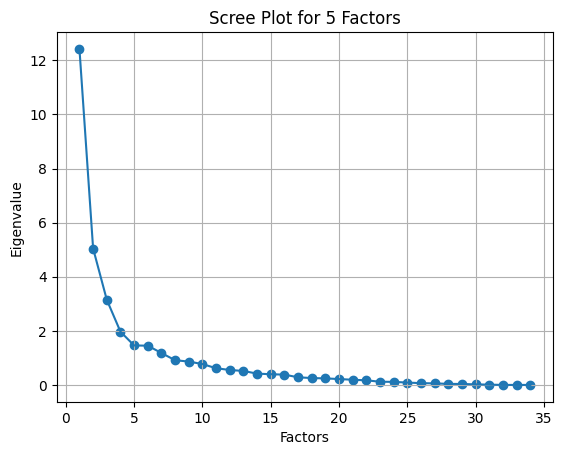

Factor Loadings for 5 Factors:
                       Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
lacking_canopy_z       0.016827  0.992392 -0.023154  0.095014  0.008312
pop_density_z          0.357950  0.150567  0.210340  0.296210  0.156738
total_pop_z            0.039182  0.253690  0.127499  0.285032  0.069811
homeowners_core_z      0.617403  0.046004 -0.132373  0.105076  0.748803
total_core_z           0.892733 -0.070906  0.057209  0.376601  0.116646
tennants_core_z        0.851242 -0.097706  0.108996  0.408300 -0.100346
owners_30pct_z        -0.083811  0.262185  0.515694  0.252775  0.734443
total_30pct_z          0.369093  0.013630  0.147414  0.882361  0.243307
tennants_30pct_z       0.446810 -0.097487 -0.057516  0.873445 -0.044782
tennants_subsidized_z  0.581960 -0.094288  0.059622  0.095230 -0.098648
low_income_measure_z   0.699760 -0.150824  0.521005  0.168715  0.132698
low_income_cutoff_z    0.590601 -0.255128  0.540228  0.195428  0.133198
housing_1960_z         0.174937 -

In [55]:
# Import necessary libraries
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import pandas as pd

# Perform Factor Analysis with 5 factors
fa = FactorAnalyzer(n_factors=5, rotation='varimax', method='ml')
fa.fit(X_z)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Plot Scree Plot
plt.scatter(range(1, X_z.shape[1]+1), ev)
plt.plot(range(1, X_z.shape[1]+1), ev)
plt.title('Scree Plot for 5 Factors')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Explanation: The Scree Plot helps determine the number of factors to retain based on the eigenvalues.
# We look for the "elbow" point where the eigenvalues start to level off.
# Factors with eigenvalues greater than 1 are typically considered significant.

# Factor Loadings
loadings = fa.loadings_

# Create a DataFrame to display the factor loadings
loadings_df = pd.DataFrame(loadings, index=X_z.columns, columns=[f'Factor {i+1}' for i in range(5)])
# Print the factor loadings
print("Factor Loadings for 5 Factors:")
print(loadings_df)

# Explanation: Factor loadings represent the correlation between each variable and the factors.
# Higher absolute values indicate a stronger relationship between the variable and the factor.
# Positive values indicate a positive correlation, while negative values indicate a negative correlation.
# The factor loadings help interpret the underlying factors and their relationship with the variables.


In [56]:
# Convert the arrays to 1-dimensional
factor_loadings1 = np.array(loadings).flatten()
xgb_feature_importances1 = np.array(best_xgb_feature_importances).flatten()
rf_feature_importances1 = np.array(rf_feature_importances).flatten()

# Create a DataFrame for xgb_feature_importances and rf_feature_importances
df_xgb_rf = pd.DataFrame({
    'xgb_importances': xgb_feature_importances1,
    'rf_importances': rf_feature_importances1,
}, index=loadings_df.index)

# Merge loadings_df with df_xgb_rf
loadings_df = pd.concat([loadings_df, df_xgb_rf], axis=1)

# Calculate the average weight for each feature
loadings_df['average_weight'] = loadings_df.mean(axis=1)
# Move the 'z_columns' to the leftmost column
#loadings_df = loadings_df[['z_columns'] + [col for col in loadings_df.columns if col != 'z_columns']]

# Now you can use loadings_df['average_weight'] as your weighting array
weighting = loadings_df['average_weight'].values


In [57]:
loadings_df

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,xgb_importances,rf_importances,average_weight
lacking_canopy_z,0.016827,0.992392,-0.023154,0.095014,0.008312,0.006063,0.006600,0.157436
pop_density_z,0.357950,0.150567,0.210340,0.296210,0.156738,0.005238,0.022288,0.171333
total_pop_z,0.039182,0.253690,0.127499,0.285032,0.069811,0.009946,0.013722,0.114126
homeowners_core_z,0.617403,0.046004,-0.132373,0.105076,0.748803,0.002471,0.005032,0.198917
total_core_z,0.892733,-0.070906,0.057209,0.376601,0.116646,0.027746,0.069181,0.209887
tennants_core_z,0.851242,-0.097706,0.108996,0.408300,-0.100346,0.058682,0.051212,0.182911
owners_30pct_z,-0.083811,0.262185,0.515694,0.252775,0.734443,0.008472,0.005349,0.242158
total_30pct_z,0.369093,0.013630,0.147414,0.882361,0.243307,0.027334,0.045605,0.246964
tennants_30pct_z,0.446810,-0.097487,-0.057516,0.873445,-0.044782,0.008445,0.028514,0.165347
tennants_subsidized_z,0.581960,-0.094288,0.059622,0.095230,-0.098648,0.010318,0.023603,0.082542


In [62]:
#loadings_df['indicator'] = X_z.columns
loadings_df.to_csv('loadings_new.csv',index=False)

In [60]:
loadings_df

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,xgb_importances,rf_importances,average_weight,indicator
lacking_canopy_z,0.016827,0.992392,-0.023154,0.095014,0.008312,0.006063,0.006600,0.157436,lacking_canopy_z
pop_density_z,0.357950,0.150567,0.210340,0.296210,0.156738,0.005238,0.022288,0.171333,pop_density_z
total_pop_z,0.039182,0.253690,0.127499,0.285032,0.069811,0.009946,0.013722,0.114126,total_pop_z
homeowners_core_z,0.617403,0.046004,-0.132373,0.105076,0.748803,0.002471,0.005032,0.198917,homeowners_core_z
total_core_z,0.892733,-0.070906,0.057209,0.376601,0.116646,0.027746,0.069181,0.209887,total_core_z
tennants_core_z,0.851242,-0.097706,0.108996,0.408300,-0.100346,0.058682,0.051212,0.182911,tennants_core_z
owners_30pct_z,-0.083811,0.262185,0.515694,0.252775,0.734443,0.008472,0.005349,0.242158,owners_30pct_z
total_30pct_z,0.369093,0.013630,0.147414,0.882361,0.243307,0.027334,0.045605,0.246964,total_30pct_z
tennants_30pct_z,0.446810,-0.097487,-0.057516,0.873445,-0.044782,0.008445,0.028514,0.165347,tennants_30pct_z
tennants_subsidized_z,0.581960,-0.094288,0.059622,0.095230,-0.098648,0.010318,0.023603,0.082542,tennants_subsidized_z


In [62]:
# Assuming factor_loadings is a 2D array with shape (34, 5)
# and xgb_feature_importances and rf_feature_importances are 1D arrays with shape (34,)

# Aggregate factor loadings into a single array
factor_loadings_aggregated = np.mean(factor_loadings, axis=1)

# Check if the lengths match
assert len(factor_loadings_aggregated) == len(best_xgb_feature_importances) == len(rf_feature_importances), "Lengths must match"

# Stack the three 1D arrays along a new third axis to create a 3D array
weights_3d = np.stack((factor_loadings_aggregated, best_xgb_feature_importances, rf_feature_importances), axis=1)

# Aggregate the 3D array into a 1D array
weighting = np.mean(weights_3d, axis=1)

# Now you can use this weighting array to calculate the weighted scores
vi_columns_array = df_cleaned.filter(like='_VI').values
weighted_scores = np.dot(vi_columns_array, weighting)

# Print the weighted scores
print("Weighted Scores for Each Row:")
print(weighted_scores)

Weighted Scores for Each Row:
[14.27491254  9.50195    11.98976813 10.58389453  9.9175982  11.41360724
 10.02477839  7.3222172   7.73550879 10.43998875  8.44425979 12.9665747
 11.54380705 12.23235749 10.28071175  9.61659705  8.50642645 11.50373903
  7.81651014  9.62041654 10.10818121 10.80830878 10.9118051  13.11277927
  9.17167489 12.06586275 10.36973869  7.50455413  9.49084517 11.31934825
 10.58461139 10.56309888 14.79672675 10.27452904  9.8016907   9.9405219
 12.33514643  8.27611045  7.48309493 11.18561349 12.25681713 10.5987028
 12.04185235 14.19416631  7.02803573 10.41646199 13.46163933  9.73047331
  7.5364444  10.93064655  9.69683596  8.84440451 11.90285558  8.5760135
 15.51376066  9.6995185  10.14326705 12.25593786  6.60108553  9.77967323
  8.3553031  13.04470568  9.85484382  9.34611729  8.26881917 10.72997529
  7.42348463  8.90326685 10.34439348 11.04898666  7.99796923  6.34640664
  9.04736948 12.59644022 10.69446217 10.89786457 13.42838522 10.36259728
  7.88657367  8.95681026 

In [63]:
df_cleaned['weighted_score'] = weighted_scores

In [58]:

# Convert z_columns to a NumPy array and transpose it
z_columns_transposed = np.array(z_columns).T

# Check if z_columns_transposed has more than one dimension
if z_columns_transposed.ndim > 1:
    # Calculate the row-wise aggregation of all columns in z_columns_transposed
    row_aggregation = np.sum(z_columns_transposed, axis=1)

    # Apply the weights to the row-wise aggregation
    weighted_scores = np.dot(row_aggregation, weighting)

    # Print the weighted scores
    print("Weighted Scores for Each Row:")
    print(weighted_scores)
else:
    print("z_columns_transposed does not have more than one dimension.")


z_columns_transposed does not have more than one dimension.


<Axes: >

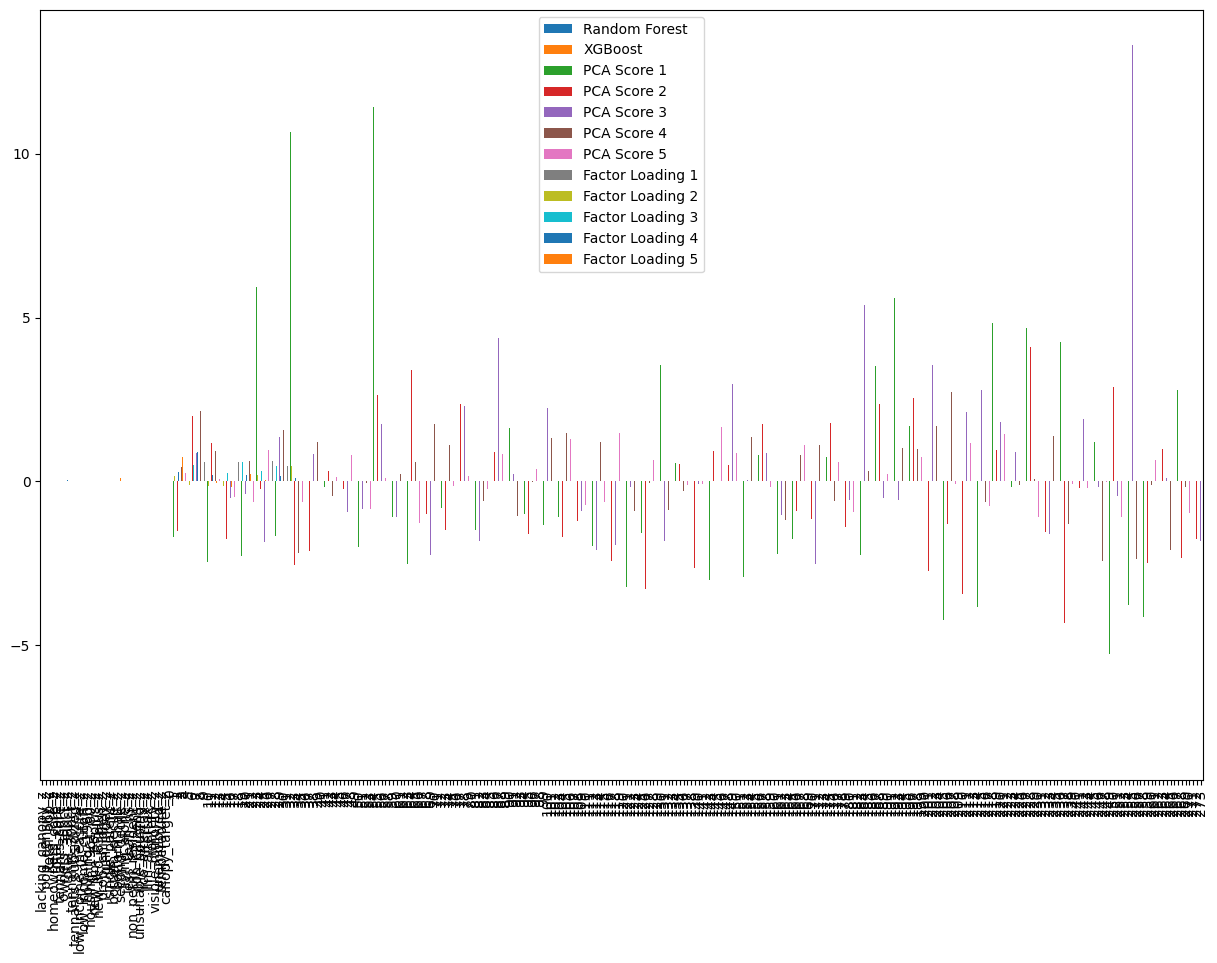

In [48]:
comparison_df.plot(kind='bar', figsize=(15, 10))

In [57]:
# Convert z_columns to a NumPy array
z_columns_array = np.array(z_columns)

# Create a weighting array
# The length of this array should be equal to the number of columns in z_columns
# Replace this with your actual weights
weighting = np.array([0.2, 0.3, 0.5])

# Check if the number of weights matches the number of columns
assert len(weighting) == z_columns_array.shape[1], "Number of weights must match number of columns"

# Apply the weights to the columns and sum them up
weighted_scores = np.dot(z_columns_array, weighting)

# Print the weighted scores
print("Weighted Scores for Each Row:")
print(weighted_scores)

IndexError: tuple index out of range

In [64]:
df_cleaned

,neighbourhood,lacking_canopy_z,pop_density_z,total_pop_z,homeowners_core_z,total_core_z,tennants_core_z,owners_30pct_z,total_30pct_z,tennants_30pct_z,...,unsuitable_housing_z_VI,lico_aftertax_z_VI,lim_aftertax_z_VI,renters_z_VI,visible_minority_z_VI,unemployed_z_VI,temperature_z_VI,canopy_target_z_VI,unweighted_score,weighted_score
0,ABBOTTSFIELD,0.717509,1.001598,-0.688575,1.072485,1.487266,1.405917,0.212180,0.604482,0.586400,...,6,6,6,4,4,3,5,4,158,14.274913
1,ALBANY,1.383038,-0.869779,-0.731552,-0.115825,-0.777320,-0.875576,0.898069,0.289850,-0.063045,...,3,4,3,4,4,3,3,5,112,9.501950
2,ALBERTA AVENUE,-1.545291,0.924028,1.093012,1.459977,1.243387,0.997047,0.261172,0.875065,0.868768,...,4,4,4,4,4,5,3,2,137,11.989768
3,ALDERGROVE,-0.081127,0.381038,0.676918,0.581661,0.546592,0.457339,-0.490040,0.308728,0.558164,...,5,3,3,3,4,4,4,3,124,10.583895
4,ALLARD,1.516144,1.593878,1.917387,-0.451652,-0.352275,-0.270449,0.702101,0.566726,0.332270,...,4,3,3,3,5,3,4,5,119,9.917598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,WILD ROSE,0.983721,1.528428,1.962317,-0.477484,-0.491634,-0.425819,-0.000119,-0.691801,-0.776023,...,5,3,3,3,5,3,4,4,118,9.633274
270,WINDERMERE,0.318191,-0.258107,3.691160,-0.038327,-0.456794,-0.523948,0.783755,0.390532,0.099316,...,3,3,3,3,5,3,4,4,116,9.446358
271,WINDSOR PARK,-2.477033,-0.852810,-0.799924,-1.381633,-1.606507,-1.447993,-0.571693,-0.207268,0.014606,...,3,5,4,3,4,2,2,1,107,8.496619
272,WOODCROFT,-0.613550,-0.514249,-0.325225,0.090838,1.926247,2.231834,-0.147095,1.095307,1.292319,...,3,4,5,5,3,3,3,3,140,12.443395


In [65]:
df_cleaned.to_csv('working_scorecard.csv', index=False)